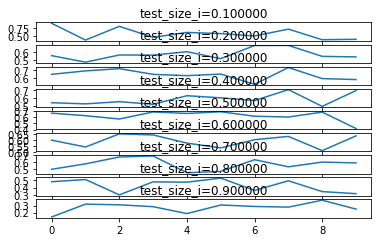

In [8]:
#coding: utf-8
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
import jieba
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn import metrics
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from numpy import vstack
import matplotlib.pyplot as plt

def MakeWordsSet(words_file):
    """
    函数说明:读取文件里的内容，并去重
    Parameters:
        words_file - 文件路径
    Returns:
        words_set - 读取的内容的set集合
    """
    words_set = set()
    with open(words_file, 'r') as fp:
        for line in fp.readlines():
            word = line.strip()#.decode("utf-8")
            if len(word)>0 and word not in words_set: # 去重
                words_set.add(word)
    return words_set

def TextProcessing(folder_path, test_size=0.2):
########################################### 使用 #######################################################
# folder_path = './Database/SogouC/Sample'
    """
    函数说明:中文文本处理
    Parameters:
        folder_path - 文本存放的路径
        test_size - 测试集占比，默认占所有数据集的百分之20
    Returns:
        all_words_list - 按词频降序排序的训练集列表
        train_data_list - 训练集列表
        test_data_list - 测试集列表
        train_class_list - 训练集标签列表
        test_class_list - 测试集标签列表
    """
    folder_list = os.listdir(folder_path)
    data_list = []
    class_list = []
###################################################################################
# data_list  ： 全部文本信息list
# class_lsit ： 每个txt文件的类别标签
    # 类间循环
    for folder in folder_list:
        new_folder_path = os.path.join(folder_path, folder)
        files = os.listdir(new_folder_path)
        # 类内循环
        j = 1
        for file in files:
            if j > 100: # 每类text样本数最多100
                break
            with open(os.path.join(new_folder_path, file), 'r') as fp:
               raw = fp.read()
           
            word_cut = jieba.cut(raw, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut) # genertor转化为list，每个词unicode格式
          
            data_list.append(word_list)
            class_list.append(folder)#.decode('utf-8')
            j += 1

    # 划分训练集和测试集
    data_class_list = list(zip(data_list, class_list))
    random.shuffle(data_class_list)
    index = int(len(data_class_list)*test_size)#+1
    train_list = data_class_list[index:]
    test_list = data_class_list[:index]
    train_data_list, train_class_list = zip(*train_list)
    test_data_list, test_class_list = zip(*test_list)

    # 统计词频放入all_words_dict
    all_words_dict = {} 
    for word_list in train_data_list:
        for word in word_list:
            #if all_words_dict.has_key(word):
            if word in all_words_dict.keys():
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # 根据键的值倒序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 内建函数sorted参数需为list
    #all_words_list = list(zip(*all_words_tuple_list))[0]
    all_words_list = list(zip(*all_words_tuple_list))[0]

    return all_words_list, train_data_list, test_data_list, train_class_list, test_class_list

def words_dict(all_words_list, deleteN, stopwords_set=set()):
    """
    函数说明:文本特征选取
    Parameters:
        all_words_list - 训练集所有文本列表
        deleteN - 删除词频最高的deleteN个词
        stopwords_set - 指定的结束语
    Returns:
        feature_words - 特征集
    """
    # 选取特征词
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > 1000: # feature_words的维度1000
            break
        # 如果这个词不是数字，并且不是指定的结束语，并且单词长度大于1小于5，那么这个词就可以作为feature_word
        if not all_words_list[t].isdigit() and all_words_list[t] not in stopwords_set and 1<len(all_words_list[t])<5:
            feature_words.append(all_words_list[t])
            n += 1
    return feature_words

def TextFeatures(train_data_list, test_data_list, feature_words):
    """
    函数说明:根据feature_words将文本向量化
    Parameters:
        train_data_list - 训练集
        test_data_list - 测试集
        feature_words - 特征集
    Returns:
        train_feature_list - 训练集向量化列表
        test_feature_list - 测试集向量化列表
    """
    def text_features(text, feature_words):
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

def TextClassifier(train_feature_list, test_feature_list, 
                    train_class_list, test_class_list,):
    """
    函数说明:分类器
    Parameters:
        train_feature_list - 训练集向量化的特征文本
        test_feature_list - 测试集向量化的特征文本
        train_class_list - 训练集分类标签
        test_class_list - 测试集分类标签
        classifier      - 使用的分类器函数
        params          - 分类器要优化的参数
    Returns:
        test_accuracy - 分类器精度
    """
    train_feature_list = list(train_feature_list)
    train_class_list = list(train_class_list)
    test_feature_list = list(test_feature_list)
    test_class_list = list(test_class_list)

    X_train = train_feature_list
    Y_train  = train_class_list

    X_train_c = np.copy(train_feature_list)
    Y_train_c  = np.copy(train_class_list)
    
    X_val  = test_feature_list
    Y_val = test_class_list

    len_X_train = len(X_train)
    len_X_val = len(X_val)

    X = vstack([X_train,X_val])
    X = np.array(X)
    Y_train.extend(Y_val)
    Y = np.array(Y_train)

    #Mark the training-validation splits
    train_i = np.ones((len_X_train,), dtype = int) * -1
    valid_i = np.zeros((len_X_val,), dtype = int)
    split_fold = np.concatenate((train_i, valid_i))
    ps = PredefinedSplit(split_fold)
    
    params = {'alpha':np.linspace(0.0001,1,10000)}
    classifier = MultinomialNB()
    
    param_search = GridSearchCV(classifier,
                            params, 
                    scoring=metrics.make_scorer(metrics.f1_score, average='macro'),
                                cv=ps,
                                return_train_score=True)
    param_search.fit(X,Y)
    results = param_search.cv_results_
    best_params = param_search.best_params_ 
    
    clf = MultinomialNB(alpha = best_params['alpha'])
    clf.fit(X_train_c,Y_train_c)
    Y_pred = clf.predict(X_val)
    test_accuracy = metrics.f1_score(Y_val, Y_pred, average='macro')

    return test_accuracy

if __name__ == '__main__':
    #acc = []
    ################################ 训练集 测试集划分比例 ###################################################
    loop = 1
    for test_size_i in [i/10 for i in range(1,10)]:
        acc = []    
        for i in range(10):
    # 文本预处理
            folder_path = './Database/SogouC/Sample'
            all_words_list, train_data_list, test_data_list, train_class_list, test_class_list = TextProcessing(folder_path, test_size = test_size_i )

    # 生成stopwords_set
            stopwords_file = './stopwords_cn.txt'
            stopwords_set = MakeWordsSet(stopwords_file)

    # 文本特征提取和分类
            deleteN = 450
            feature_words = words_dict(all_words_list, deleteN, stopwords_set)
    
    #acc = []
    #for i in range(10):
            train_feature_list, test_feature_list = TextFeatures(train_data_list, test_data_list, feature_words)

            m = TextClassifier(train_feature_list, test_feature_list, 
                    train_class_list, test_class_list)
            acc.extend([m])
        plt.subplot(10,1,loop)
        plt.title("test_size_i=%f"%(test_size_i))
        plt.plot(acc)
        loop += 1
